# Training

This notebook loads the ETL data and trains the LSTM. 

In [4]:
%load_ext lab_black

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
import os.path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [6]:
x_train = xr.load_dataarray("../data/etl/x_train.nc")
x_val = xr.load_dataarray("../data/etl/x_val.nc")
y_train = xr.load_dataarray("../data/etl/y_train.nc")
y_val = xr.load_dataarray("../data/etl/y_val.nc")

In [7]:
xdims = dict(zip(x_train.dims, x_train.shape))
ydims = dict(zip(y_train.dims, y_train.shape))
print(xdims, ydims)

{'samples': 274136, 'lookback': 90, 'features': 6} {'samples': 274136, 'features': 4}


In [5]:
input_shape = (xdims["lookback"], xdims["features"])
print(input_shape)


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend

# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    return backend.mean(backend.square(y_pred - y_true), axis=-1)


# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res = backend.sum(backend.square(y_true - y_pred))
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true)))
    return 1 - SS_res / (SS_tot + backend.epsilon())


def bias(y_true, y_pred):
    return backend.mean(y_pred) - backend.mean(y_true)


metrics = [rmse, mse, r_square, bias]


def make_model_1(var, ydims=None):
    # design network
    name = f"1_layer_lstm_{var}"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_2(var, ydims=None):
    # design network
    name = f"2_layer_lstm_{var}"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_3(var, ydims=None):
    # design network
    name = f"3_layer_lstm_{var}"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_4(var, ydims=None):
    # design network
    name = f"3_layer_lstm_wide_{var}"
    model = Sequential(name=name)
    model.add(LSTM(40, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(40, return_sequences=True))
    model.add(LSTM(40))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model

(90, 6)


In [6]:
# train the model
# history = {}
# for batch_size in [128, 512, 2048, 8192, 16384]:
#     model = make_model_1()
#     history[batch_size] = model.fit(x_train.values, y_train.values,
#                         validation_data=(x_val.values, y_val.values),
#                          batch_size=batch_size, epochs=30,
#                          shuffle=True, callbacks=callbacks)

# plt.figure(figsize=(12, 12))
# # plot training history
# for batch, h in history.items():
# #     plt.plot(h.history['loss'], label=f'train-{batch}')
#     plt.plot(h.history['val_loss'], label=f'test-{batch}')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()

# based on this, I'm using the batch_size of 512 for now

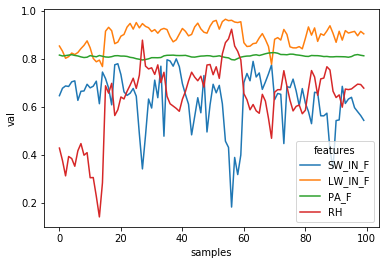

In [7]:
y_val[:100].plot.line(x="samples")

In [ ]:
batch_size = 512
history = {}


def make_callbacks(name):
    mc = ModelCheckpoint(
        f"best_{name}.h5",
        monitor="val_mse",
        mode="max",
        verbose=0,
        save_best_only=True,
    )
    es = EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=20)
    return [es, mc]

for var in y_train.features.values:
    yt = y_train.sel(features=var)
    yv = y_val.sel(features=var)
    ydims = dict(zip(yt.dims, yt.shape))
    if 'features' not in ydims:
        ydims['features'] = 1
    
    for model in [make_model_1(var, ydims), make_model_2(var, ydims), make_model_3(var, ydims), make_model_4(var, ydims)]:
        # for model in [make_model_1()]:
        model.summary()
        history[model.name] = model.fit(
            x_train.values,
            yt.values,
            validation_data=(x_val.values, yv.values,),
            batch_size=batch_size,
            epochs=500,
            shuffle=True,
            callbacks=make_callbacks(model.name),
        )

Model: "1_layer_lstm_SW_IN_F"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2160      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
Train on 274136 samples, validate on 63528 samples
Epoch 1/500
274136/274136 [==============================] - 8s 28us/sample - loss: 0.0201 - rmse: 0.1060 - mse: 0.0201 - r_square: 0.6375 - bias: -0.0060 - val_loss: 0.0117 - val_rmse: 0.0826 - val_mse: 0.0117 - val_r_square: 0.7283 - val_bias: 0.0024
Epoch 2/500
274136/274136 [==============================] - 4s 16us/sample - loss: 0.0111 - rmse: 0.0805 - mse: 0.0111 - r_square: 0.8006 - bias: -4.4948e-05 - val_loss: 0.0102 - val_rmse: 0.0757 - val

In [17]:
h.history.keys()

dict_keys(['loss', 'rmse', 'mse', 'r_square', 'bias', 'val_loss', 'val_rmse', 'val_mse', 'val_r_square', 'val_bias'])

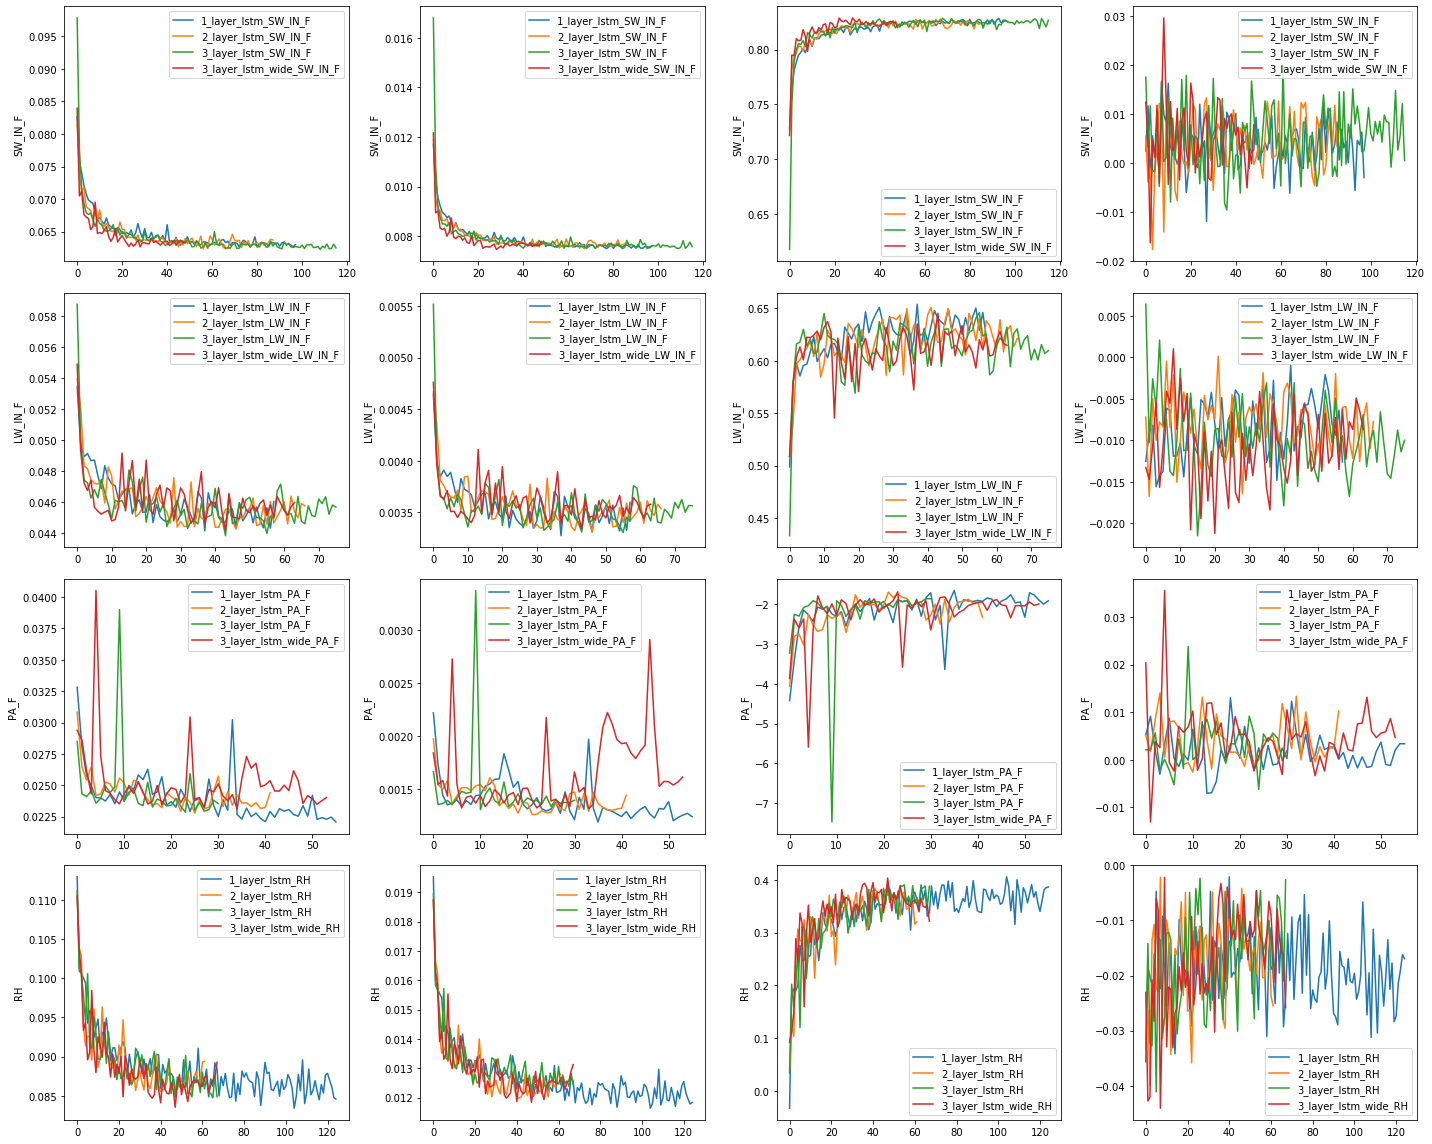

In [22]:
scores = [
    #     "val_loss",
    "val_rmse",
    "val_mse",
    "val_r_square",
    "val_bias",
]

fig, axes = plt.subplots(ncols=len(scores), nrows=4, figsize=(20, 16))
for i, var in enumerate(y_train.features.values):
    for j, score in enumerate(scores):
        # plot training history
        plt.sca(axes[i, j])
        for model, h in history.items():
            if var in model:
                plt.plot(h.history[score], label=model)
        plt.ylabel(var)
        # plt.yscale('log')
        # plt.xscale('log')
        plt.legend()
plt.tight_layout()

In [21]:
print("here")

here


In [30]:
from joblib import dump

hdump = {}

for k, v in history.items():
    hdump[k] = v.history

In [32]:
dump(hdump, "train_history.joblib")

['train_history.joblib']

In [1]:
from joblib import load

In [2]:
hdump = load("train_history.joblib")

In [33]:
scores_df = pd.DataFrame()
for var in y_train.features.values:
    var_scores = {}
    for model, scores in hdump.items():
        if var in model:
            key = model.replace("_" + var, "")
            var_scores[key] = max(scores["r_square"])
    scores_df[var] = pd.Series(var_scores)

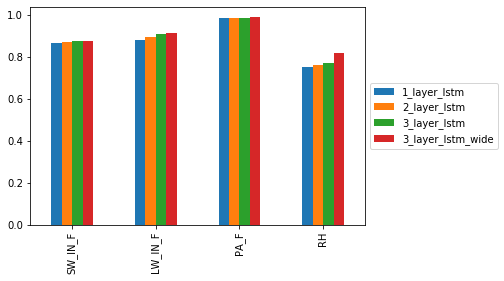

In [34]:
scores_df.T.plot.bar()
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

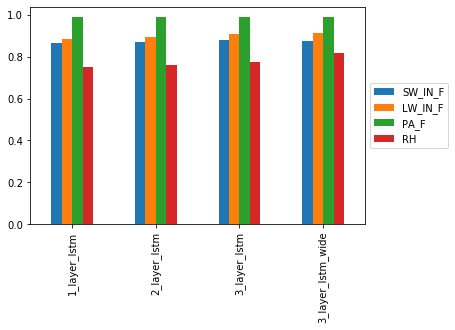

In [35]:
scores_df.plot.bar()
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

Based on this analysis, it seems like the 3_layer_lstm_wide model is performing best for all four variables. We'll go with that for now.